In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
import re
import shutil
import datetime
import pickle
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

In [ ]:
from tensorflow import keras
from keras import Model
from keras.layers import Dense, Dropout, Activation, Rescaling, \
Flatten, Input, Conv3D, MaxPool3D, BatchNormalization
from keras.optimizers import Adadelta
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.metrics import CategoricalAccuracy, Recall, Precision
from tensorflow_addons.metrics import F1Score

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
DEPTH = 36
LABELS = ["ForwardFall", "BackwardFall", "LeftFall", "RightFall", "GetDown", "SitDown", "Walk"]
LABEL2INDEX = dict(zip(LABELS, range(len(LABELS))))
INDEX2LABEL = dict(zip(range(len(LABELS)), LABELS))

In [ ]:
def load_dataset(ds_name):
  with open(ds_name + '/element_spec', 'rb') as in_:
    es = pickle.load(in_)

  dataset = tf.data.Dataset.load(
      ds_name, es, compression='GZIP'
  )
  return dataset

def show_result(history):
  print(history.history.keys())
  plt.plot(history.history['categorical_acc'])
  plt.plot(history.history['val_categorical_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()



  plt.plot(history.history['pre'])
  plt.plot(history.history['val_pre'])
  plt.title('model precision')
  plt.ylabel('precision')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()



  plt.plot(history.history['recall'])
  plt.plot(history.history['val_recall'])
  plt.title('model recall')
  plt.ylabel('recall')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()


  plt.plot(history.history['f1'])
  plt.plot(history.history['val_f1'])
  plt.title('model f1 score')
  plt.ylabel('f1 score')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

# 7 labels

In [ ]:
path = "cnn3d"
train_ds = load_dataset(os.path.join(path, "train"))
val_ds = load_dataset(os.path.join(path,"val"))
test_ds = load_dataset(os.path.join(path, "test"))

In [ ]:
_, train_count = np.unique([output.numpy() for _, output in train_ds],return_counts= True)
_, val_count = np.unique([output.numpy() for _, output in val_ds],return_counts= True)
_, test_count = np.unique([output.numpy() for _, output in test_ds],return_counts= True)

x = pd.DataFrame({"Train": train_count, "Val": val_count, "Test": test_count}, index= LABEL2INDEX)
x.loc["Total"] = {"Train": sum(train_count), "Val": sum(val_count), "Test": sum(test_count)}
display(x)

,Train,Val,Test
ForwardFall,2749,916,917
BackwardFall,2758,919,919
LeftFall,2774,925,925
RightFall,2780,927,927
GetDown,2617,873,872
SitDown,2677,893,892
Walk,2777,925,926
Total,19132,6378,6378


In [ ]:
def reshape(tensor):
  return tf.reshape(tensor, [IMAGE_WIDTH, IMAGE_HEIGHT, DEPTH, 1])

def one_hot_encode_label(label):
  label = tf.cast(label, dtype=tf.int32)
  return tf.one_hot(label, depth=7)

train_ds = train_ds.map(lambda x, y: (reshape(x), one_hot_encode_label(y)))
val_ds = val_ds.map(lambda x, y: (reshape(x), one_hot_encode_label(y)))
test_ds = test_ds.map(lambda x, y: (reshape(x), one_hot_encode_label(y)))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 2**6
train_ds = train_ds.cache().batch(batch_size=BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().batch(batch_size=BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().batch(batch_size=BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
def build_model(img_height=IMAGE_HEIGHT, img_width=IMAGE_WIDTH, depth= DEPTH):
  def set_seed(num_seed):
        SEED = num_seed
        # os.environ['PYTHONHASHSEED']=str(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        random.seed(SEED)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
  set_seed(1)

  inputs = Input((img_width, img_height, depth, 1))
  x = Rescaling(scale = 1./255, offset=0.0)(inputs)
  x = Conv3D(filters=10, kernel_size=3, activation="relu")(x)
  x = MaxPool3D(pool_size=2)(x)
  x = BatchNormalization()(x)
  x = Flatten()(x)
  x = Dense(units = 1200,activation = 'relu')(x)
  x = Dropout(rate = 0.2)(x)
  x = BatchNormalization()(x)
  x = Dense(units = 600,activation = 'relu')(x)
  x = Dropout(rate = 0.2)(x)
  x = BatchNormalization()(x)
  outputs = Dense(units=7, activation="softmax", kernel_regularizer=tf.keras.regularizers.l1(0.004),
                                              activity_regularizer=tf.keras.regularizers.l2(0.004))(x)
  # Define the model.
  model = Model(inputs, outputs, name="3dcnn")
  model.compile(
            optimizer = tf.keras.optimizers.Adadelta(learning_rate=46e-4, rho=0.95, epsilon=1e-08),
            loss = 'categorical_crossentropy',
            metrics =[
                      CategoricalAccuracy(name='categorical_acc') ,
                      Precision(name='pre'),
                      Recall(name='recall'),
                      F1Score(num_classes=7, name = 'f1', average='weighted'),
            ])
  return model

In [ ]:
cnn_model = build_model()
cnn_model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 36, 1)]   0         
                                                                 
 rescaling_1 (Rescaling)     (None, 32, 32, 36, 1)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 30, 34, 10)    280       
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 15, 15, 17, 10)    0         
 g3D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 15, 15, 17, 10)    40        
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 38250)             0     

In [ ]:
today = str(datetime.date.today())
f1_modelcheckpoint_callback = ModelCheckpoint(
    today + '_3dcnn_model',
    monitor='val_f1',
    verbose=1,
    save_best_only=True,
    mode='max'
)

In [ ]:
dir = os.path.join("cnn3d", today + "_3dcnn_model")
if os.path.isdir(dir):
  shutil.rmtree(dir)

history = cnn_model.fit(
    train_ds,
    epochs=2,
    validation_data= val_ds,
    callbacks=[
        f1_modelcheckpoint_callback
    ]
)

Epoch 1/2
298/299 [============================>.] - ETA: 0s - loss: 1.5352 - categorical_acc: 0.7724 - pre: 0.8789 - recall: 0.6913 - f1: 0.7717
Epoch 1: val_f1 improved from -inf to 0.82299, saving model to 2024-04-22_3dcnn_model
299/299 [==============================] - 23s 69ms/step - loss: 1.5343 - categorical_acc: 0.7727 - pre: 0.8789 - recall: 0.6917 - f1: 0.7720 - val_loss: 1.9288 - val_categorical_acc: 0.8192 - val_pre: 1.0000 - val_recall: 0.1944 - val_f1: 0.8230
Epoch 2/2
299/299 [==============================] - ETA: 0s - loss: 0.9624 - categorical_acc: 0.9765 - pre: 0.9857 - recall: 0.9648 - f1: 0.9765
Epoch 2: val_f1 improved from 0.82299 to 0.99781, saving model to 2024-04-22_3dcnn_model
299/299 [==============================] - 17s 58ms/step - loss: 0.9624 - categorical_acc: 0.9765 - pre: 0.9857 - recall: 0.9648 - f1: 0.9765 - val_loss: 0.9007 - val_categorical_acc: 0.9978 - val_pre: 0.9992 - val_recall: 0.9955 - val_f1: 0.9978


dict_keys(['loss', 'categorical_acc', 'pre', 'recall', 'f1', 'val_loss', 'val_categorical_acc', 'val_pre', 'val_recall', 'val_f1'])


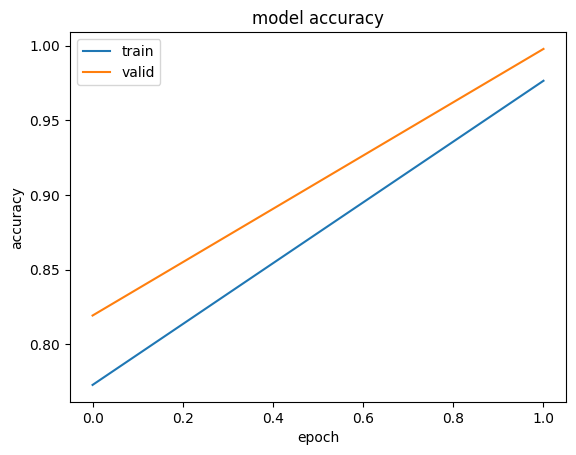

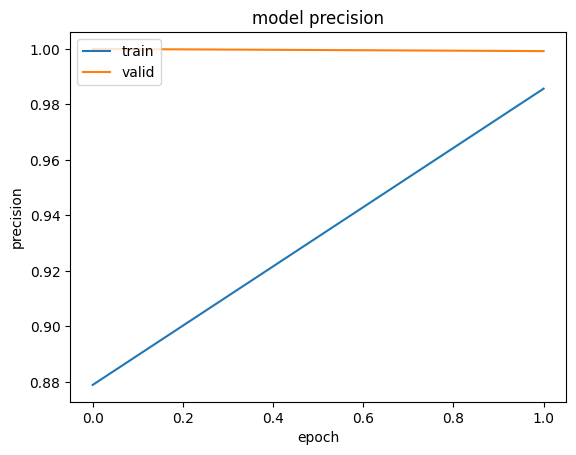

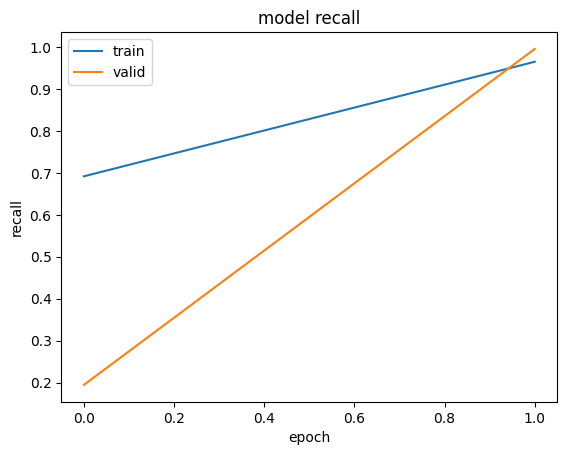

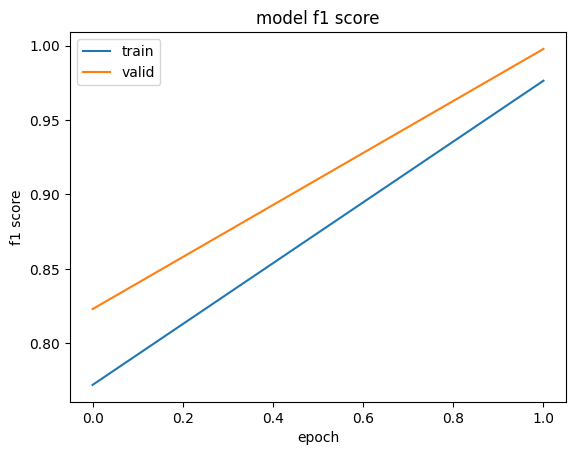

In [ ]:
show_result(history)

In [ ]:
print(cnn_model.evaluate(val_ds))

100/100 [==============================] - 1s 13ms/step - loss: 0.9007 - categorical_acc: 0.9978 - pre: 0.9992 - recall: 0.9955 - f1: 0.9978
[0.900730311870575, 0.9978049397468567, 0.9992130994796753, 0.9954531192779541, 0.997805118560791]


In [ ]:
print(cnn_model.evaluate(test_ds))

100/100 [==============================] - 3s 28ms/step - loss: 0.8986 - categorical_acc: 0.9987 - pre: 0.9992 - recall: 0.9955 - f1: 0.9987
[0.898571252822876, 0.9987456798553467, 0.9992130994796753, 0.9954531192779541, 0.9987457394599915]


In [ ]:
y_pred = []
y_true = []

for batch, label in test_ds:
   y_true.append(label)
   preds = cnn_model.predict(batch, verbose=0)
   y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
conf_matrix = confusion_matrix(tf.math.argmax(correct_labels, axis=1), predicted_labels.numpy())
confusion_df = pd.DataFrame(conf_matrix)
confusion_df = confusion_df.rename(index=INDEX2LABEL, columns=INDEX2LABEL)
display(confusion_df)
f1_score(tf.math.argmax(correct_labels, axis=1), predicted_labels.numpy(), average=None)

,ForwardFall,BackwardFall,LeftFall,RightFall,GetDown,SitDown,Walk
ForwardFall,917,0,0,0,0,0,0
BackwardFall,0,919,0,0,0,0,0
LeftFall,0,0,921,0,0,4,0
RightFall,0,0,1,925,0,0,1
GetDown,0,0,0,0,872,0,0
SitDown,0,0,0,0,0,890,2
Walk,0,0,0,0,0,0,926


array([1.        , 1.        , 0.99729291, 0.99892009, 1.        ,
       0.99664054, 0.99838275])

# 2 labels

In [ ]:
path = "cnn3d"
train_ds = load_dataset(os.path.join(path, "train"))
val_ds = load_dataset(os.path.join(path,"val"))
test_ds = load_dataset(os.path.join(path, "test"))

In [ ]:
def one_hot_encode_label(label):
  label = tf.cast(label, dtype=tf.int32)
  label = 1 if label>3 else 0
  return tf.one_hot(label, depth=2)

train_ds = train_ds.map(lambda x, y: (reshape(x), one_hot_encode_label(y)))
val_ds = val_ds.map(lambda x, y: (reshape(x), one_hot_encode_label(y)))
test_ds = test_ds.map(lambda x, y: (reshape(x), one_hot_encode_label(y)))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 2**6
train_ds = train_ds.cache().batch(batch_size=BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().batch(batch_size=BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().batch(batch_size=BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
def build_model_2_labels(img_height=IMAGE_HEIGHT, img_width=IMAGE_WIDTH, depth= DEPTH):
  def set_seed(num_seed):
    SEED = num_seed
    # os.environ['PYTHONHASHSEED']=str(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    random.seed(SEED)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
  set_seed(1)

  inputs = Input((img_width, img_height, depth, 1))
  x = Rescaling(scale = 1./255, offset=0.0)(inputs)
  x = Conv3D(filters=10, kernel_size=3, activation="relu")(x)
  x = MaxPool3D(pool_size=2)(x)
  x = BatchNormalization()(x)
  x = Flatten()(x)
  x = Dense(units = 1200,activation = 'relu')(x)
  x = Dropout(rate = 0.2)(x)
  x = BatchNormalization()(x)
  x = Dense(units = 600,activation = 'relu')(x)
  x = Dropout(rate = 0.2)(x)
  x = BatchNormalization()(x)
  outputs = Dense(units=2, activation="softmax", kernel_regularizer=tf.keras.regularizers.l1(0.004),
                                              activity_regularizer=tf.keras.regularizers.l2(0.004))(x)

  # Define the model.
  model = Model(inputs, outputs, name="3dcnn")
  model.compile(
            optimizer = Adadelta(learning_rate=46e-5, rho=0.95, epsilon=1e-08),
            loss = 'categorical_crossentropy',
            metrics =[
                      CategoricalAccuracy(name='categorical_acc') ,
                      Precision(name='pre'),
                      Recall(name='recall'),
                      F1Score(num_classes=2, name = 'f1', average='weighted'),

            ])
  return model

In [ ]:
cnn_model = build_model_2_labels()
cnn_model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 36, 1)]   0         
                                                                 
 rescaling_2 (Rescaling)     (None, 32, 32, 36, 1)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 30, 30, 34, 10)    280       
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 15, 15, 17, 10)    0         
 g3D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 15, 15, 17, 10)    40        
 chNormalization)                                                
                                                                 
 flatten_2 (Flatten)         (None, 38250)             0     

In [ ]:
today = str(datetime.date.today())
f1_modelcheckpoint_callback = ModelCheckpoint(
    today + '_2labels_3dcnn_model',
    monitor='val_f1',
    verbose=1,
    save_best_only=True,
    mode='max'
)

In [ ]:
dir = os.path.join("cnn3d", today + "_2labels_3dcnn_model")
if os.path.isdir(dir):
  shutil.rmtree(dir)

history = cnn_model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=[
        f1_modelcheckpoint_callback
    ]
)

Epoch 1/5
298/299 [============================>.] - ETA: 0s - loss: 0.8523 - categorical_acc: 0.7228 - pre: 0.7228 - recall: 0.7228 - f1: 0.7245
Epoch 1: val_f1 improved from -inf to 0.47901, saving model to 2024-04-22_2labels_3dcnn_model
299/299 [==============================] - 30s 91ms/step - loss: 0.8521 - categorical_acc: 0.7230 - pre: 0.7230 - recall: 0.7230 - f1: 0.7247 - val_loss: 0.7919 - val_categorical_acc: 0.6038 - val_pre: 0.6038 - val_recall: 0.6038 - val_f1: 0.4790
Epoch 2/5
299/299 [==============================] - ETA: 0s - loss: 0.5279 - categorical_acc: 0.8853 - pre: 0.8853 - recall: 0.8853 - f1: 0.8859
Epoch 2: val_f1 improved from 0.47901 to 0.96630, saving model to 2024-04-22_2labels_3dcnn_model
299/299 [==============================] - 17s 55ms/step - loss: 0.5279 - categorical_acc: 0.8853 - pre: 0.8853 - recall: 0.8853 - f1: 0.8859 - val_loss: 0.3888 - val_categorical_acc: 0.9663 - val_pre: 0.9663 - val_recall: 0.9663 - val_f1: 0.9663
Epoch 3/5
298/299 [====

In [ ]:
show_result(history)

In [ ]:
print(cnn_model.evaluate(val_ds))

100/100 [==============================] - 1s 13ms/step - loss: 0.2852 - categorical_acc: 0.9936 - pre: 0.9936 - recall: 0.9936 - f1: 0.9936
[0.2851746678352356, 0.9935716390609741, 0.9935716390609741, 0.9935716390609741, 0.9935771226882935]


In [ ]:
print(cnn_model.evaluate(test_ds))

100/100 [==============================] - 3s 28ms/step - loss: 0.2852 - categorical_acc: 0.9939 - pre: 0.9939 - recall: 0.9939 - f1: 0.9939
[0.28522810339927673, 0.9938852190971375, 0.9938852190971375, 0.9938852190971375, 0.9938889741897583]


In [ ]:
y_pred = []
y_true = []

for batch, label in test_ds:
   y_true.append(label)
   preds = cnn_model.predict(batch, verbose=0)
   y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
conf_matrix = confusion_matrix(tf.math.argmax(correct_labels, axis=1), predicted_labels.numpy())
confusion_df = pd.DataFrame(conf_matrix)
confusion_df = confusion_df.rename(index= {0:"Fall", 1:"Not_Fall"}, columns={0:"Fall", 1: "Not_Fall"})
display(confusion_df)
f1_score(tf.math.argmax(correct_labels, axis=1), predicted_labels.numpy(), average=None)

,Fall,Not_Fall
Fall,3656,32
Not_Fall,7,2683


array([0.9946946 , 0.99278446])